# Salesforce XGen tutorial

## Table of contents

1. Introduction
2. XGen 7B key features and capabilities
3. Applications of XGen 7B
4. Prerequisites and installation
5. Working with XGen 7B
6. Maximizing model performance
7. Building a summarizer model
8. Conclusion

## Introduction

Right now, these six are the hottest open-source LLMs:

1. LLaMA2
2. BLOOM
3. Falcon 180B
4. OPT-175B
5. GPT-Neox
6. Vicuna 13-B

And they all have the same disadvantage - very short context length, reaching up to only 2048 tokens. Compared to proprietary models like GPT-3.5 and GPT-4 that offer lengths up to 32k tokens (50 pages of text!), it seems open-source LLMs are at a heavy disadvantage. 

Context length is essentially the "memory" of LLMs. 2048-token context window means the model can only remember 2048 tokens of the conversation at a time. This significantly affects performance in tasks where a large context is crucial such as summarization, translation, code generation, etc. 

To address this critical issue, Salesforce announced its XGen-7B model with a whopping context length of 8k tokens (4 times longer than other LLMs). This article covers the key characteristics of the model and show to build a text summarizer model using it. 

## Why choose XGen 7B over others?

For most, statistics like context length don't mean much until they are translated into tangible benefits. So, here are some of its main features and the impact they can have in your own projects:

**Compact yet powerful**

Despite its relatively small size of 7 billion parameters, XGen punches well above its weight - delivering performance that rivals or exceeds that of much larger models. This efficiency is a game-changer for developers and researchers, enabling running and deployment of cutting-edge AI applications directly on high-end local machines without access to vast cloud computing resources. This balance between size and performance makes XGen particularly appealing for a wide array of users, from small startups to academic researchers.


**Versatile model variants**

Understanding various user needs, XGen offers three versions, each suited for specific applications:
   - XGen-7B-4K-base: With a 4k token sequence length, this version is suited for tasks requiring moderate context sizes. It's licensed under Apache 2.0 license.
   - XGen-7B-8K-base: This is the flagship model boasting an 8k token sequence length, designed for complex tasks that benefit from analyzing large blocks of text. Like its sibling, it's available under the Apache 2.0 license, which means it can be used for almost any purpose.
   - XGen-7B-{4K,8K}-inst: Fine-tuned on public instructional data, these models are specialized for interactive and instructional applications, available for non-commercial use. This variant is ideal for educational tools, interactive bots, and other applications where guidance or instruction is important.

**High performance on benchmarks**

The true measure of the model's strength is reflected in the benchmarks. XGen comes out on top for diverse set of benchmarks such as MMLU, HumanEval and so on when compared to models of similar size.  For an in-depth analysis, the [announcement post](https://blog.salesforceairesearch.com/xgen/#results-on-standard-benchmarks) provides a comprehensive overview of XGen's achievements across benchmarks.

**Optimization for long-sequence tasks**

At the risk of redundancy, I reiterate that XGen is highly-optimized for tasks that require large context windows. This capability is critical for applications like detailed document summarization, where understanding the entirety of a text is important for generating accurate summaries. Similarly, in comprehensive question answering and long-form content generation, XGen's ability to process large amounts of information results in more coherent, contextually relevant outputs.

## XGen 7B training details

So, how does XGen achieve these impressive results? Of course, the answer lies in the training and optimization methods used by Salesforce AI researchers.

The training strategy of XGen consists of two stages. In stage 1, a fresh model is trained on 1.37 trillion tokens, containing a mix of natural language data and code.

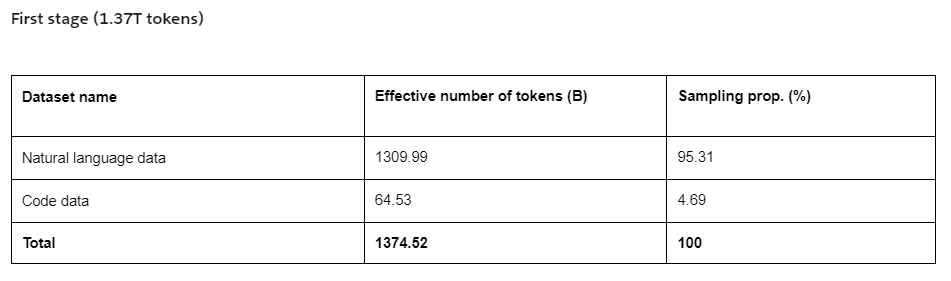

In stage two, additional 55 billion tokens of code were used to train for better code generation:

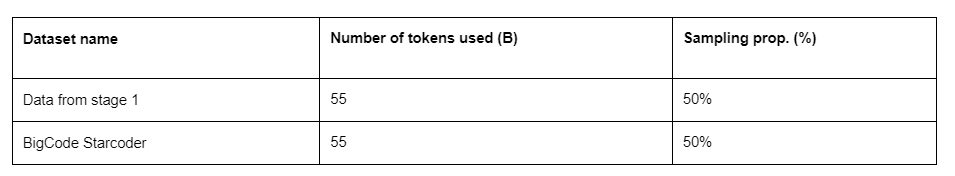

The training was done using an in-house library called [JaxFormer](https://github.com/salesforce/jaxformer) specifically designed for efficient LLMs training under both data and model parallelism for TPU-v4 hardware.

## Prerequisites and installation

Despite its small size, XGen 7B is still pretty massive in terms of neural networks. This requires high-end local machines if you decide to install without cloud resources. The primary requirement is sufficiently large RAM, well above 32 GB as the model is ~30 GB to download from HuggingFace. As for GPU, the bigger the better.

If your PC doesn't have these specs, the cheapest option is Colab Pro which comes with 40 GB RAM and GPU vRAM (A100s). For this tutorial, I am using Colab Pro:

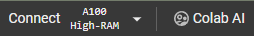

After setting up a compatible machine, it is time to install and download the model. If you are following along locally, step 0 is creating a virtual environment:

```shell
$ conda create -n xgen -y
$ conda activate xgen
```

To download the model from HuggingFace, it is a requirement that `torch` with GPU-support is installed. Here is the command for installing all the required libraries:

```
$ pip install torch torchvision torchaudio transformers[torch]
```

We will also need the following libraries for fine-tuning step later:

```
$ pip install accelerate peft bitsandbytes trl datasets --upgrade
```

Don't forget to restart the kernel after installing the libraries.

> I will explain each library once we get to that section. 

```python
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("Salesforce/xgen-7b-8k-base", trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained("Salesforce/xgen-7b-8k-base", torch_dtype=torch.bfloat16)

inputs = tokenizer("DataCamp is one he ...", return_tensors="pt")
sample = model.generate(**inputs, max_length=128)

print(tokenizer.decode(sample[0]))
```

The `AutoTokenizer` class loads the auto-tokenizer for the 4098 length model `xgen-7b-4k-base`. `AutoModelForCausalLM` class is for loading models for text generation. 

We are specifying the prompt as `inputs` and unpacking it inside `model.generate` specifying a maximum token length of 128. The code above will take a while when run first time as the model needs to be downloaded. 

Here is the output I received:

```
DataCamp is one of the world’s leading providers of data science courses and training...
```

The response is all right but we can improve it by fine-tuning the model on a small instruction dataset.

## Fine-tuning XGen 7B

LLMs are not like `sklearn` models - you can't just tune their hyperparameters in a few lines of code. So, we will fine-tune XGen in several steps. I suggest you go through each step by taking deep breaths as there will be lots of details.

> Note that the workflow I will outline below will work for many LLMs on HuggingFace as long as you have enough compute power.

Let's start.

#### 1. Installation

We've already covered this step earlier. So, let's review the libraries we've installed and why we need them:

- `torch`: PyTorch library for tensors and neural networks; enables GPU acceleration.
- `transformers`: Hugging Face's library for pre-trained NLP models.
- `datasets`: For easy data loading and processing with HuggingFace datasets.
- `accelerate`: Official HuggingFace library to simplify distributed training of LLMs.
- `peft`: a package to fine-tune a small fraction of LLM parameters to accelerate training
- `bitsandbytes`: optimization library for LLMs in terms of memory and computational efficiency. 
- `trl`: Techniques for fine-tuning large models using RLHF (reinforcement learning with human feedback).

We will explain the benefits of each library when we arrive at their usage.

#### 2. Importing necessary modules

```python
import os
import torch

from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
)

from peft import LoraConfig
from trl import SFTTrainer
```

Here is an overview of the new classes and functions we are importing:

- **`BitsAndBytesConfig`**: Configuration for optimizing model parameters with bits and bytes techniques, enhancing memory and computational efficiency.
- **`TrainingArguments`**: Specifies training parameters (e.g., learning rate, batch size) for fine-tuning models.
- **`pipeline`**: Simplifies the process of applying models to tasks like text generation.
- **`LoraConfig`**: Configuration for applying LoRA (Low-Rank Adaptation), a parameter-efficient fine-tuning method that adjusts a small set of parameters to adapt the model..
- **`SFTTrainer`**: Trainer class for Supervised Fine-Tuning (SFT), facilitating the training process with human feedback or labeled datasets.


#### 3. Define the configs for base and tuned model

```python
# Model from HF
base_model = "Salesforce/xgen-7b-8k-base"

# New instruction dataset
guanaco_dataset = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model
new_model = "xgen-7b-8k-tuned"
```

For the dataset, we will be using the Guanaco LLaMA2 dataset which contains 1000 instruction-output pairs to tune LLMs for interactive and instructional tasks (think chatbots). 

#### 4. Load the data

```
dataset = load_dataset(guanaco_dataset, split="train")```


To load the data from HuggingFace, we use the `load_dataset` function specifying the path and the split of the dataset. We can view samples of the dataset by converting to a text format and indexing a random instruction-output pair:

```
dataset["text"][89]

<s>[INST] In England, what vegetable is referred to as a rocket? [/INST] The species name for "rocket" is "Eruca vesicaria", and it's also sometimes called "eruca".
However, other countries have different names for it:
* Arugula - America
* Garden Rocket or Rocket - Britain, Australia, South Africa, Ireland, New Zealand

Other names include "ruchetta", "rucola", "rucoli", "rugula", "colewoort", and "roquette".

The word transferred from Latin to Italian to English, which might explain the variants with similar pronunciation. </s>
```

#### 5. Define quantization parameters

Quantization is a powerful technique used in machine learning to reduce the number of bits to represent data. This is done by approximating the original data with a smaller number of bits, resulting in a more compact representation. Quantization can be used to reduce the memory footprint of a model, improve computational efficiency, and sometimes even improve accuracy.

```python
compute_dtype = torch.float16

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)
```

First, we set the data type for each tensor with `compute_dtype` to `float16`. Then, using the `BitsAndBytesConfig`, we define the following quantization parameters:
- `load_in_4bit=True`: This specifies that the input data will be quantized to 4 bits.
- `bnb_4bit_compute_dtype=compute_dtype`: This specifies the data type to use for computations, which is set to `float16` retrieved earlier.
- `bnb_4bit_quant_type="nf4"`: This specifies the quantization type for 4-bit quantization, in this case, `"nf4"`.

`nf4` refers to a specific type of quantization that uses non-uniform quantization with 4 bits. Non-uniform quantization can sometimes be better than plain uniform.

#### 6. Define the model and its parameters

```python
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map="auto"
)
```

This step is similar to our initial download of XGen but this time, we are passing in the quantization parameters to `quantization_config` and setting `device_map` to auto so that GPU is automatically used.


#### 7. Load the tokenizer

```
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"
```

After we load the tokenizer, we configure padded token parameters. In NLP, padded tokens are special symbols with no meaning and they are added to each input token so that all tokens have the same size. Tokens of fixed size are requirement for many model architectures in NLP. 

`tokenizer.pad_token = tokenizer.eos_token` sets the padding token of the tokenizer to be the same as the end-of-sentence (EOS) token. This is a common practice in NLP, as it allows the model to distinguish between the end of a sentence and padded tokens. `tokenizer.padding_side = "right"` specifies that padding should be added to the right side of the input sequences.

#### 8. PEFT parameters

```python
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)
```

Pre-trained LLMs require massive amounts of data and compute resources to fine-tine. By using Parameter-efficient Fine-tuning (PEFT), we can fine-tune only a fraction of the total model parameters leading to significant decrease in runtime. You can read more about this technique from the [official documentation](https://huggingface.co/docs/peft/conceptual_guides/lora).

The `LoraConfig` class sets the configurations of Low-Rank Adaptation method. LoRA is a specific type of parameterization used in PEFT. Overall, the above code snippet controls the strength of adaptation of LoRA layers, the number of trainable parameters, and other aspects of the layers.

#### 9. Setting training parameters

```
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
)
```

Apart from everything else we've defined, fine-tuning XGen requires about a dozen more training parameters. These include familiar parameters like learning rate, learning rate schedulers, number of epochs, optimizers and some new ones such as `warmup_ratio`, `fp16`, `bf16`, `weight_decay`, etc. To stay focused, we won't cover what all these parameters do, so I refer you to this [excellent article](https://www.datacamp.com/tutorial/fine-tuning-llama-2) on fine-tuning LLaMA2 that explain them.

#### 10. Tune it finally!

To fine-tune a PEFT model, we will use the `SFTTrainer` (Supervised fine-tuning) class from `trl` library, a key step in RLFH. 

```python
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_params,
    dataset_text_field="text",
    max_seq_length=None,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)
```

To initialize the trainer, we provide it with the model, training dataset, PEFT parameters, training parameters and the tokenizer. To launch fine-tuning, we only have to call `.train()`:

```
trainer.train()
```

Based on the training parameters (especially the number of epochs), the training may take anywhere from 15 minutes to hours. 

#### 11. Evaluating

Once training finishes, we can finally test our fine-tuned model:

```python
prompt = "Who wrote Python?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)

result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])
```

Before passing the prompt to the fine-tuned `model`, we first pass the `model` and the `tokenizer` into a pipeline. `pipeline` function is used to load pre-trained models, preprocess the input by using the tokenizer and apply (if any) custom post-processing steps to generated text. 

Above, we are running the pipeline with specially formatted prompt wrapped with `<s>[INST] {prompt} [/INST]`, exactly like instructions used during training. And here is the result:

```
<s>[INST] Who wrote Python? [/INST] Python was created by Guido van Rossum, a Dutch computer programmer. He started working on the language in the late 1980s and released the first version in 1991. </s>

Python is a high-level, general-purpose programming language that is widely used in various fields, including data science, machine learning, and web development. It is known for its readability, flexibility, and ease of use, making it a popular choice for beginners and experienced developers alike. </s>

Python is an open-source language, meaning that anyone can access and modify the source code, making it a popular choice for developers who want to contribute to the community. </s>...
```

#### 12. Save the model and tokenizer

Once we are satisfied with our model, we can finally save it:

```
trainer.model.save_pretrained(new_model)
trainer.tokenizer.save_pretrained(new_model)
```

You can load it back using the `AutoModelForCausalLM` class again:

```
fine_tuned_xgen = AutoModelForCausalLM.from_pretrained(new_model, ...)

```

## Conclusion

Starting with Large Language Models (LLMs) like Salesforce's XGen 7B is straightforward, but customizing them for specific needs is more complex. Our experience fine-tuning the XGen 7B model on a small instructional dataset illustrates the challenge. Adapting the model to various tasks requires access to relevant datasets (available through Hugging Face's datasets library) and computational resources that can manage the training of a model with 7 billion parameters across those datasets.

The fine-tuning process can be summarized into the following steps:

1. Installation of libraries
2. Importing necessary modules
3. Defining the global configs
4. Loading a dataset for fine-tuning
5. Defining quantization parameters with `bitsandbytes`
6. Defining the model and its init parameters through `transformers`
7. Loading a tokenizer suitable to the model
8. Defining PEFT parameters with LoRA as layers with `LoraConfig`
9. Setting training parameters through `transformers`
10. Tuning the model with `SFTTrainer` from `trl`
11. Test/evaluate the model with sample prompts
12. Saving the model and the tokenizer for later use

If certain concepts or code snippets still feel unfamiliar or fuzzy, I recommend these excellent resources:
- [LLMs concepts course](https://app.datacamp.com/learn/courses/large-language-models-llms-concepts)
- [Introduction to LLMs in Python](https://app.datacamp.com/learn/courses/introduction-to-llms-in-python)
- [Fine-tuning Mistral 7B](https://www.datacamp.com/tutorial/mistral-7b-tutorial)

Thank you for reading!